# Задачи условной оптимизации

- 1
В соответствии с вашим вариантом напишите программу определения минимума
функции с использованием Метода штрафов (к целевой функции добавляется функция, которая
представляет собой штраф за нарушение каждого ограничения).
- 2
В соответствии с вашим вариантом напишите программу определения минимума
функции с использованием Метода барьеров (к целевой функции добавляется слагаемое, которое
не позволяет генерировать новые точки за областью дополнительных значений)

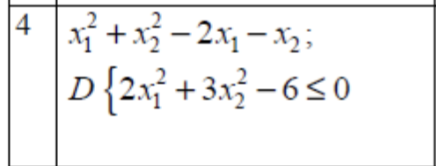

### Метод барьеров:
- **Барьер**: Барьерная функция всегда стремится к бесконечности, когда точка приближается к границе допустимой области. В методе барьеров вместо штрафа для каждой точки за нарушение ограничения используется логарифмическая функция (или аналогичные), которая становится очень большой, когда решение приближается к границе допустимого множества.
- **Применение**: Метод барьеров используется для «отталкивания» решения от границы допустимой области, предотвращая попадание в нее. Барьерная функция исчезает (становится менее значимой), как только решение оказывается в допустимой области.
- **Реализация коде**: В коде используется функция `helper_func`, которая включает логарифмическое выражение, связанное с ограничением. Это выражение растет очень быстро, когда точка приближается к границе ограничения (то есть к границе допустимой области).



### Метод штрафов:
- **Штрафы**: Метод штрафов добавляет к целевой функции штрафы, пропорциональные квадрату нарушения ограничений (или другим функциям нарушения). Эти штрафы увеличиваются по мере того, как решение удаляется от допустимой области.
- **Применение**: Метод штрафов используется для «выпрямления» целевой функции, чтобы решения, нарушающие ограничения, были менее привлекательными для оптимизатора.
- **Реализация коде**: В примере используется функция `penalty_function`, которая добавляет штраф к целевой функции за нарушение ограничения, когда значение ограничения больше нуля. Штраф увеличивается с каждым шагом, что заставляет оптимизатор стремиться к удовлетворению ограничениям.



# Метод барьеров

In [7]:
import numpy as np
from tabulate import tabulate

# Класс для хранения параметров алгоритма
class Params:
    tolerance = 0.002  # Порог для завершения алгоритма
    penalty_param = 5.0  # Начальное значение штрафного параметра
    penalty_multiplier = 4  # Коэффициент для увеличения штрафа
    step_alpha = 0.1  # Параметр для метода обратного отслеживания
    step_beta = 0.8  # Коэффициент уменьшения шага

# Целевая функция
def objective_function(x1, x2):
    return x1**2 + x2**2 - 2*x1 - x2

# Ограничение задачи
def constraint(x1, x2):
    return 2*x1**2 + 3*x2**2 - 6

# Вспомогательная функция для барьерного метода
def barrier_function(x1, x2):
    constraint_value = constraint(x1, x2)
    if constraint_value >= 0:
        return float('inf')  # На случай, если точка вне допустимого множества
    return objective_function(x1, x2) - Params.penalty_param * np.log(-constraint_value)

# Функция штрафа
def penalty_function(x1, x2):
    constraint_value = constraint(x1, x2)
    if constraint_value >= 0:
        return float('inf')
    return -Params.penalty_param * np.log(-constraint_value)

# Вычисление градиента функции
def compute_gradient(func, x1, x2):
    h = 1e-5  # Маленькое число для аппроксимации производной
    grad_x1 = (func(x1 + h, x2) - func(x1 - h, x2)) / (2 * h)
    grad_x2 = (func(x1, x2 + h) - func(x1, x2 - h)) / (2 * h)
    return [grad_x1, grad_x2]

# Умножение вектора на число
def multiply_vector(vec, scalar):
    return [v * scalar for v in vec]

# Вычитание векторов
def subtract_vectors(vec1, vec2):
    return [v1 - v2 for v1, v2 in zip(vec1, vec2)]

# Метод обратного отслеживания для поиска подходящего шага
def backtracking_line_search(func, current_point, gradient, initial_lambda=1.0):
    lambda_ = initial_lambda
    current_func_value = func(*current_point)
    
    while True:
        new_point = subtract_vectors(current_point, multiply_vector(gradient, lambda_))
        new_func_value = func(*new_point)
        grad_norm_squared = sum(g**2 for g in gradient)

        if new_func_value <= current_func_value - Params.step_alpha * lambda_ * grad_norm_squared:
            break

        lambda_ *= Params.step_beta  # Уменьшаем шаг
    return lambda_


def cauchy_method(func, initial_point):
    current_point = initial_point[:]
    iteration_count = 0
    
    while iteration_count < 100:
        gradient_at_current = compute_gradient(func, current_point[0], current_point[1])
        step_size = backtracking_line_search(func, current_point, gradient_at_current)
        next_point = subtract_vectors(current_point, multiply_vector(gradient_at_current, step_size))

        if abs(func(*next_point) - func(*current_point)) <= Params.tolerance:
            return next_point
        
        current_point = next_point
        iteration_count += 1
    
    return [0, 0]  # Если не сходится, возвращаем [0,0]

# Основная функция, которая запускает оптимизацию
def perform_optimization():
    iteration = 0
    initial_point = [0.8, -0.3]  # Начальная точка
    results = []  # Список для хранения результатов

    while True:
        # Поиск минимума вспомогательной функции
        optimal_point = cauchy_method(barrier_function, initial_point)

        # Сохраняем результат текущей итерации
        results.append([iteration + 1, initial_point[0], initial_point[1], optimal_point[0], optimal_point[1], Params.penalty_param])

        # Обновляем точку
        initial_point = optimal_point

        # Проверка, если ограничения выполнены и сходимость достигнута
        if constraint(*initial_point) <= 0:
            if abs(penalty_function(*initial_point)) <= Params.tolerance:
                print("\nРезультаты оптимизации:")
                print(tabulate(results, headers=["Итерация", "x1", "x2", "Оптим. x1", "Оптим. x2", "r_k"], tablefmt="grid"))
                print(f"\nИтоговая точка: {initial_point[0]:.5f} {initial_point[1]:.5f}")
                print(f"Количество итераций: {iteration + 1}")
                print(f'Значение минимума функции: {objective_function(initial_point[0], initial_point[1])}')
                return
            else:
                Params.penalty_param /= Params.penalty_multiplier
                iteration += 1


In [8]:
perform_optimization()


Результаты оптимизации:
+------------+----------+-----------+-------------+-------------+------------+
|   Итерация |       x1 |        x2 |   Оптим. x1 |   Оптим. x2 |        r_k |
+============+==========+===========+=============+=============+============+
|          1 | 0.8      | -0.3      |    0.363432 |    0.147628 | 5          |
+------------+----------+-----------+-------------+-------------+------------+
|          2 | 0.363432 |  0.147628 |    0.654215 |    0.270903 | 1.25       |
+------------+----------+-----------+-------------+-------------+------------+
|          3 | 0.654215 |  0.270903 |    0.835419 |    0.375869 | 0.3125     |
+------------+----------+-----------+-------------+-------------+------------+
|          4 | 0.835419 |  0.375869 |    0.990517 |    0.497008 | 0.078125   |
+------------+----------+-----------+-------------+-------------+------------+
|          5 | 0.990517 |  0.497008 |    0.986911 |    0.487662 | 0.0195312  |
+------------+----------+--

In [4]:
constraint(0.8, -0.3)

-4.449999999999999

# Метод штрафов

In [9]:
import math
from tabulate import tabulate

class Config:
    tolerance = 1e-4  # Пороговое значение для завершения работы алгоритма
    penalty_param = 1  # Начальное значение штрафного параметра
    penalty_increase_factor = 8  # Коэффициент увеличения штрафа
    alpha = 0.1  # Параметр для метода обратного отслеживания
    beta = 0.8  # Параметр уменьшения шага в методе обратного отслеживания

# Умножение вектора на число
def multiply_vector(vec, scalar):
    return [v * scalar for v in vec]

# Вычитание двух векторов
def subtract_vectors(vec1, vec2):
    return [v1 - v2 for v1, v2 in zip(vec1, vec2)]

# Вычисление градиента функции
def compute_gradient(func, x1, x2, h=1e-4):
    grad_x1 = (func(x1 + h, x2) - func(x1 - h, x2)) / (2 * h)
    grad_x2 = (func(x1, x2 + h) - func(x1, x2 - h)) / (2 * h)
    return [grad_x1, grad_x2]

# Метод обратного отслеживания (поиск шага)
def backtracking_line_search(func, current_point, gradient, initial_lambda=10.0):
    lambda_ = initial_lambda
    func_val_at_current = func(current_point[0], current_point[1])

    while True:
        new_point = subtract_vectors(current_point, multiply_vector(gradient, lambda_))
        func_val_at_new = func(new_point[0], new_point[1])
        gradient_norm_squared = sum(g**2 for g in gradient)

        if func_val_at_new <= func_val_at_current - Config.alpha * lambda_ * gradient_norm_squared:
            break

        lambda_ *= Config.beta  # Уменьшаем шаг
    return lambda_


def cauchy_optimization(func, start_point):
    current_point = start_point[:]
    iteration = 0
    while iteration < 100:
        gradient_at_current = compute_gradient(func, current_point[0], current_point[1])
        step_size = backtracking_line_search(func, current_point, gradient_at_current)
        next_point = subtract_vectors(current_point, multiply_vector(gradient_at_current, step_size))

        if abs(func(next_point[0], next_point[1]) - func(current_point[0], current_point[1])) <= Config.tolerance:
            return next_point
        
        current_point = next_point
        iteration += 1
    return [0, 0]  # Если не сходится, возвращаем точку (0,0)

# Целевая функция для минимизации
def objective_function(x1, x2):
    return x1**2 + x2**2 - 2*x1 - x2

# Ограничение задачи
def constraint_function(x1, x2):
    return 2 * x1**2 + 3 * x2**2 - 6

# Функция для штрафа, если ограничение нарушено
def penalty_function(x1, x2):
    constraint_value = constraint_function(x1, x2)
    return (Config.penalty_param / 2) * constraint_value**2 if constraint_value > 0 else 0

# Модифицированная функция для минимизации с учетом штрафа
def modified_function(x1, x2):
    return objective_function(x1, x2) + penalty_function(x1, x2)

# Основная функция для вычислений
def run_optimization():
    iteration_count = 0
    starting_point = [-4, -2.5]

    optimization_results = []

    while True:
        optimal_point = cauchy_optimization(modified_function, starting_point)

        # Добавляем результаты текущей итерации
        optimization_results.append([iteration_count+1, starting_point[0], starting_point[1], optimal_point[0], optimal_point[1], Config.penalty_param])
        
        starting_point = optimal_point

        # Если штрафная функция достаточно мала, завершить оптимизацию
        if penalty_function(starting_point[0], starting_point[1]) <= Config.tolerance: 
            print("\nРезультаты оптимизации:")
            print(tabulate(optimization_results, headers=["Итерация", "x1", "x2", "Оптим. x1", "Оптим. x2", "r_k"], tablefmt="grid"))
            print(f"\nИтоговая точка: {starting_point[0]:8.4f}, {starting_point[1]:8.4f}")
            print(f"Количество итераций: {iteration_count+1}")
            print(f'Значение минимума функции: {objective_function(starting_point[0], starting_point[1])}')
            return
        else:
            # Увеличиваем штрафной параметр для более строгой оптимизации
            Config.penalty_param *= Config.penalty_increase_factor
            iteration_count += 1


In [10]:
run_optimization()


Результаты оптимизации:
+------------+------+------+-------------+-------------+-------+
|   Итерация |   x1 |   x2 |   Оптим. x1 |   Оптим. x2 |   r_k |
+============+======+======+=============+=============+=======+
|          1 |   -4 | -2.5 |    0.992513 |    0.494341 |     1 |
+------------+------+------+-------------+-------------+-------+

Итоговая точка:   0.9925,   0.4943
Количество итераций: 1
Значение минимума функции: -1.2499119310619389


# Графическое представление

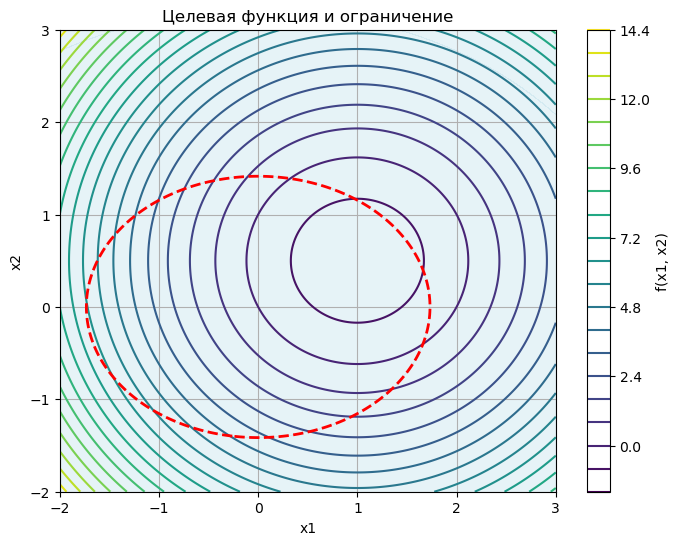

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Целевая функция
def objective_function(x1, x2):
    return x1**2 + x2**2 - 2*x1 - x2

# Ограничение
def constraint(x1, x2):
    return 2*x1**2 + 3*x2**2 - 6

# Создание сетки точек
x1 = np.linspace(-2, 3, 300)
x2 = np.linspace(-2, 3, 300)
X1, X2 = np.meshgrid(x1, x2)
Z = objective_function(X1, X2)
C = constraint(X1, X2)

# Построение графиков
plt.figure(figsize=(8, 6))

# Линии уровня целевой функции
contour = plt.contour(X1, X2, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='f(x1, x2)')

# Область, где выполняется ограничение
constraint_region = C 
plt.contourf(X1, X2, constraint_region, levels=1, colors=['lightblue'], alpha=0.3)

# Линия ограничения
plt.contour(X1, X2, C, levels=[0], colors='red', linewidths=2, linestyles='dashed')

# Оформление графика
plt.title("Целевая функция и ограничение")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid()
plt.show()
